In [42]:
# Requisitos: pip install pandas matplotlib seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
# Cargar datasets desde CSV
df_coingecko = pd.read_csv("output/coingecko/filtered_dataset.csv")
df_coinmarketcap = pd.read_csv("output/coinmarketcap/filtered_dataset.csv")

## Para CoinGecko

###**1. Resumen de los datos**

In [31]:
# Info general
df_coingecko.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98828 entries, 0 to 98827
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          98828 non-null  object 
 1   price         98828 non-null  float64
 2   total_volume  98828 non-null  float64
 3   market_cap    98823 non-null  float64
 4   coin_name     98828 non-null  object 
dtypes: float64(3), object(2)
memory usage: 3.8+ MB


In [32]:
# Primeras filas
df_coingecko.head(10)  # muestra 10 filas por ejemplo

,date,price,total_volume,market_cap,coin_name
0,2015-01-01 00:00:00.000,313.992000,4.699936e+07,4.293958e+09,bitcoin
1,2015-01-01 00:00:00.000,0.005498,8.877137e+03,1.955719e+07,stellar
2,2015-01-01 00:00:00.000,0.024376,4.332450e+05,7.551216e+08,ripple
3,2015-01-01 00:00:00.000,0.466182,2.589714e+04,2.563381e+06,monero
4,2015-01-01 00:00:00.000,2.713621,1.382349e+06,9.559803e+07,litecoin
5,2015-01-01 00:00:00.000,0.000183,2.838455e+05,1.780332e+07,dogecoin
6,2015-01-02 00:00:00.000,0.000184,3.637417e+05,1.784733e+07,dogecoin
7,2015-01-02 00:00:00.000,0.005520,2.655518e+04,1.964011e+07,stellar
8,2015-01-02 00:00:00.000,0.468605,3.957272e+04,2.577242e+06,monero
9,2015-01-02 00:00:00.000,2.679196,2.097774e+06,9.446229e+07,litecoin


In [33]:
# Forma (filas, columnas)
df_coingecko.shape

(98828, 5)

In [34]:
# Estadísticos básicos para columnas numéricas
df_coingecko.select_dtypes(include=['number']).describe().T

,count,mean,std,min,25%,50%,75%,max
price,98828.0,1.130362e+03,6.014066e+03,5.700414e-11,2.686192e-01,1.510257e+00,2.290827e+01,7.309777e+04
total_volume,98828.0,2.396623e+09,1.035824e+10,0.000000e+00,2.654641e+07,1.537116e+08,7.040172e+08,9.267677e+11
market_cap,98823.0,1.986898e+10,8.709952e+10,0.000000e+00,6.890444e+08,2.463430e+09,6.985864e+09,1.436631e+12


In [35]:
import scipy.stats as stats
numeric = df_coingecko.select_dtypes(include=['number'])
extra = numeric.agg(['skew','kurtosis']).T
extra

,skew,kurtosis
price,6.954414,52.665769
total_volume,20.535728,1312.376120
market_cap,8.395995,82.804308


In [38]:
# Conteo de nulos por columna
df_coingecko.isnull().sum()

date            0
price           0
total_volume    0
market_cap      5
coin_name       0
dtype: int64

In [ ]:
# Filas que contienen al menos un nulo
df_coingecko[df_coingecko.isnull().any(axis=1)].shape[0]

5

In [41]:
# Proporción de nulos por columna (porcentaje)
(df_coingecko.isnull().sum() / len(df_coingecko) * 100).round(3)

date            0.000
price           0.000
total_volume    0.000
market_cap      0.005
coin_name       0.000
dtype: float64

###**3.4. Preprocesamiento de los datos**

In [43]:
# Guardamos el original y creamos columna imputada
df_coingecko['market_cap_imputed'] = df_coingecko['market_cap']

# Calculamos ratio (market_cap / price) en filas válidas
mask = df_coingecko['price'].notna() & (df_coingecko['price'] != 0) & df_coingecko['market_cap'].notna()
ratios = df_coingecko.loc[mask].assign(ratio = df_coingecko.loc[mask,'market_cap'] / df_coingecko.loc[mask,'price'])

# Mediana por moneda
median_ratio_coin = ratios.groupby('coin_name')['ratio'].median()

# Mediana global como respaldo
global_median_ratio = ratios['ratio'].median()

# Función de imputación
def fill_market_cap(row):
    if not np.isnan(row['market_cap']):
        return row['market_cap']
    p = row['price']
    if pd.isna(p) or p == 0:
        return np.nan
    r = median_ratio_coin.get(row['coin_name'], np.nan)
    if pd.isna(r):
        r = global_median_ratio
    return p * r

# Aplica imputación solo donde market_cap es NA
df_coingecko.loc[df_coingecko['market_cap'].isna(), 'market_cap_imputed'] = \
    df_coingecko[df_coingecko['market_cap'].isna()].apply(fill_market_cap, axis=1)

# Verifica
print("Valores imputados:", df_coingecko['market_cap_imputed'].isna().sum())
df_coingecko[df_coingecko['market_cap'].isna()][['date','coin_name','price','market_cap','market_cap_imputed']]

Valores imputados: 0


,date,coin_name,price,market_cap,market_cap_imputed
6523,2017-04-02 00:00:00.000,dogecoin,0.000491,NaN,5.927443e+07
6524,2017-04-02 00:00:00.000,monero,20.189904,NaN,3.466532e+08
6526,2017-04-02 00:00:00.000,bitcoin,1098.068000,NaN,1.963193e+10
6527,2017-04-02 00:00:00.000,ethereum,48.378467,NaN,5.260150e+09
6530,2017-04-02 00:00:00.000,litecoin,8.011579,NaN,5.051418e+08


In [44]:
df_coingecko.isnull().sum()

date                  0
price                 0
total_volume          0
market_cap            5
coin_name             0
market_cap_imputed    0
dtype: int64

In [48]:
# Detección con IQR por coin
def detect_outliers_iqr(group, col='price'):
    Q1 = group[col].quantile(0.25)
    Q3 = group[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return group[(group[col] < lower) | (group[col] > upper)]

outliers_price = df_coingecko.groupby('coin_name', group_keys=False).apply(detect_outliers_iqr)
print("Outliers detectados en price:", len(outliers_price))
outliers_price.head()

Outliers detectados en price: 6378


C:\Users\USER\AppData\Local\Temp\ipykernel_5176\2926882905.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_price = df_coingecko.groupby('coin_name', group_keys=False).apply(detect_outliers_iqr)


,date,price,total_volume,market_cap,coin_name,market_cap_imputed
21042,2019-06-22,3.172364,1.790331e+08,1.010855e+08,algorand,1.010855e+08
21060,2019-06-23,2.159165,2.588226e+08,7.665618e+07,algorand,7.665618e+07
21100,2019-06-24,1.899598,2.100211e+08,6.647512e+07,algorand,6.647512e+07
42781,2021-02-13,1.701046,1.711699e+09,1.353377e+09,algorand,1.353377e+09
42811,2021-02-14,1.669753,1.340167e+09,1.353825e+09,algorand,1.353825e+09


In [49]:
def winsorize(group, col='price'):
  lower = group[col].quantile(0.01)
  upper = group[col].quantile(0.99)
  group[col+'_wins'] = group[col].clip(lower, upper)
  return group

df_coingecko = df_coingecko.groupby('coin_name', group_keys=False).apply(winsorize)

C:\Users\USER\AppData\Local\Temp\ipykernel_5176\2687312032.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_coingecko = df_coingecko.groupby('coin_name', group_keys=False).apply(winsorize)


In [52]:
adjusted = (df_coingecko['price'] != df_coingecko['price_wins']).sum()
print(f"Valores recortados: {adjusted}")

Valores recortados: 2017


In [54]:
df_coingecko.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98828 entries, 0 to 98827
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                98828 non-null  object 
 1   price               98828 non-null  float64
 2   total_volume        98828 non-null  float64
 3   market_cap          98823 non-null  float64
 4   coin_name           98828 non-null  object 
 5   market_cap_imputed  98828 non-null  float64
 6   price_wins          98828 non-null  float64
dtypes: float64(5), object(2)
memory usage: 8.0+ MB


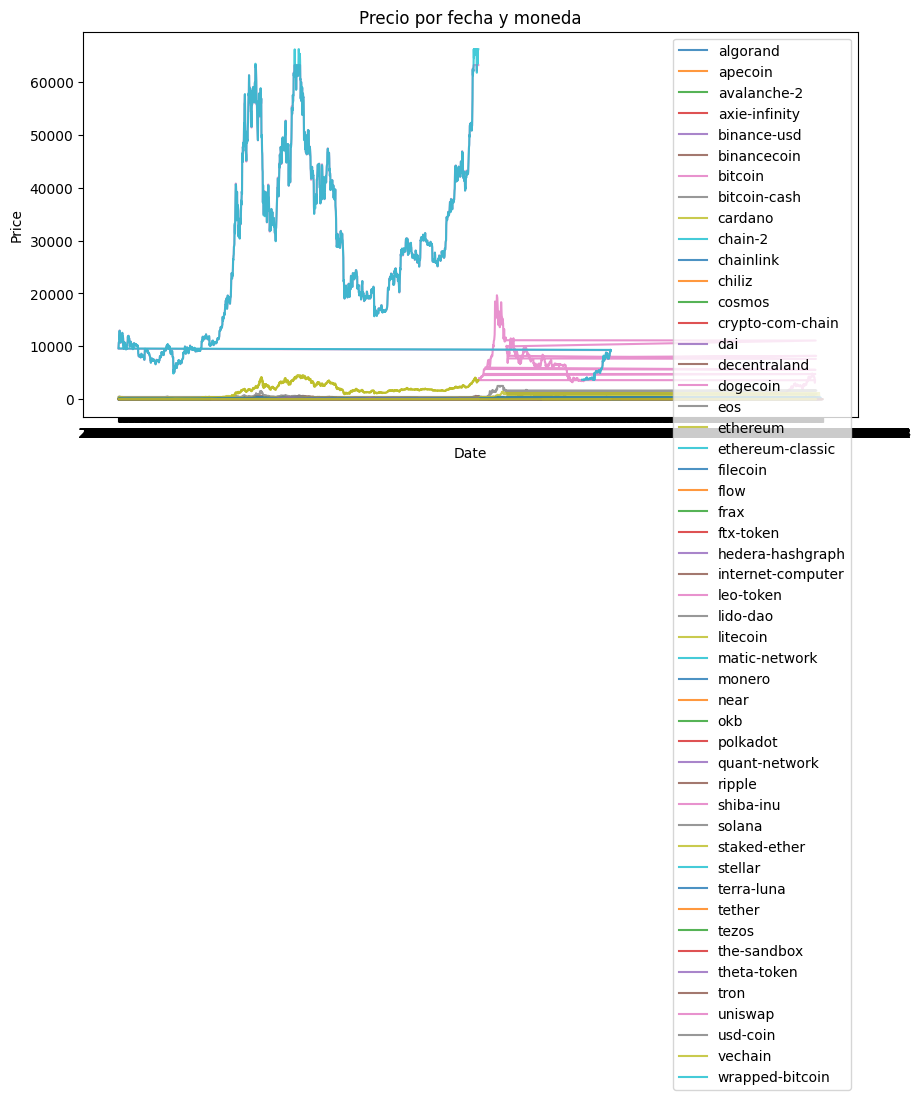

In [55]:
# Series temporal del precio por moneda (líneas)
plt.figure(figsize=(10,5))
for coin, g in df_coingecko.groupby('coin_name'):
    plt.plot(g['date'], g['price_wins'], label=coin, alpha=0.8)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Precio por fecha y moneda')
plt.show()

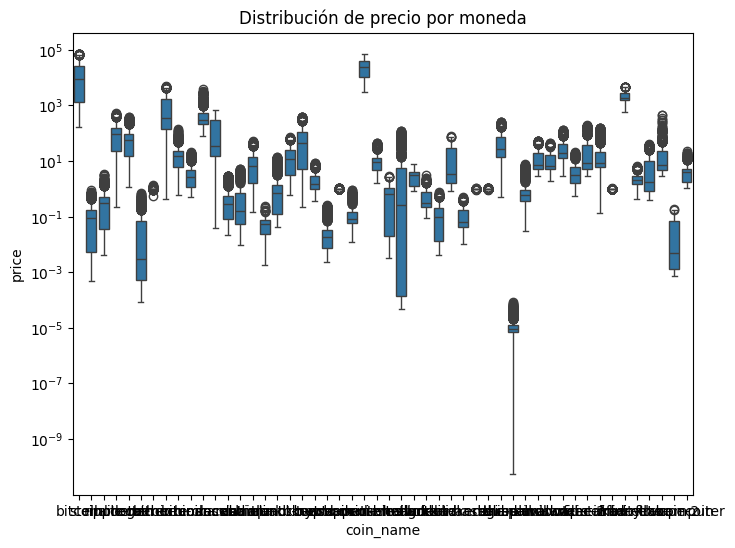

In [45]:
# Boxplot de precios por moneda
plt.figure(figsize=(8,6))
sns.boxplot(data=df_coingecko, x='coin_name', y='price')
plt.yscale('log')  # opcional
plt.title('Distribución de precio por moneda')
plt.show()

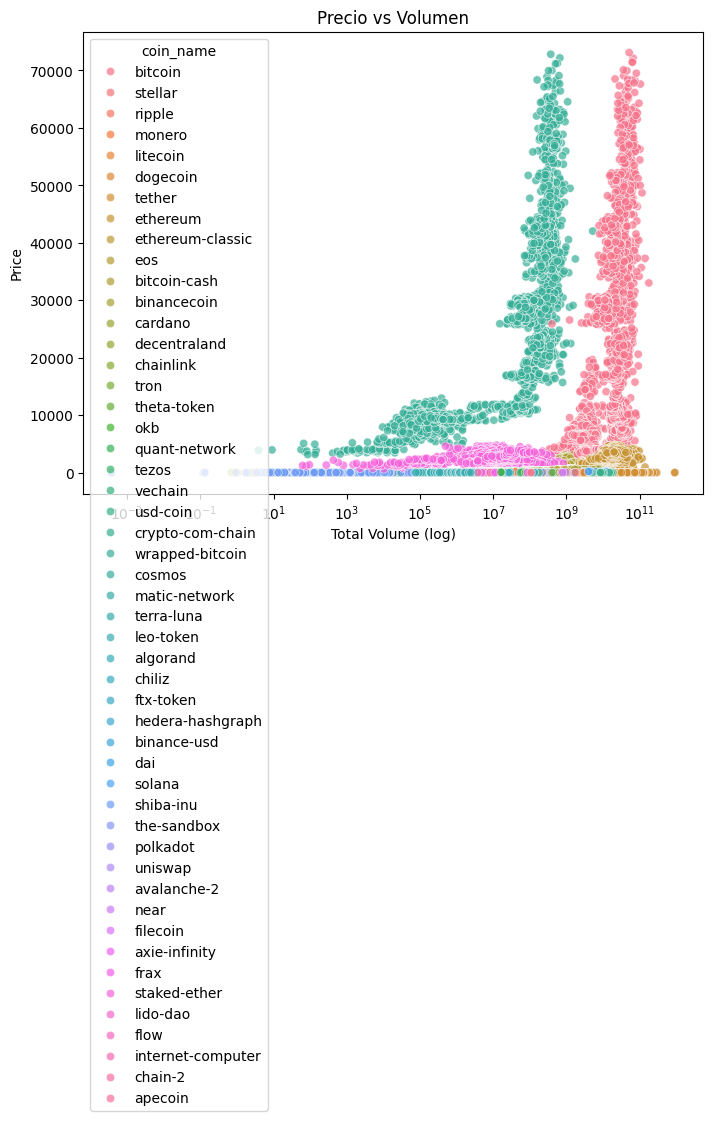

In [46]:
# Precio vs volumen (scatter) coloreado por moneda
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_coingecko, x='total_volume', y='price', hue='coin_name', alpha=0.7)
plt.xscale('log')  # opcional si hay gran rango
plt.xlabel('Total Volume (log)')
plt.ylabel('Price')
plt.title('Precio vs Volumen')
plt.show()

## Para CoinMarketCap

In [9]:
# Inspección rápida
df_coinmarketcap.head(10)        # primeras 5 filas

,id,name,slug,symbol,status,category,description,subreddit,notice,tags,...,chat,explorer,reddit,technical_doc,source_code,announcement,platform_id,date_added,date_launched,keep
0,1,Bitcoin,bitcoin,BTC,active,coin,## **What Is Bitcoin (BTC)?**\n\nBitcoin is a ...,bitcoin,NaN,"mineable, pow, sha-256, store-of-value, state-...",...,NaN,https://blockchain.coinmarketcap.com/chain/bit...,https://reddit.com/r/bitcoin,https://bitcoin.org/bitcoin.pdf,https://github.com/bitcoin/,NaN,NaN,2013-04-28T00:00:00.000Z,NaN,True
1,2,Litecoin,litecoin,LTC,active,coin,## What Is Litecoin (LTC)?\n\nLitecoin (LTC) i...,litecoin,NaN,"mineable, pow, scrypt, medium-of-exchange, bin...",...,https://telegram.me/litecoin,"https://blockchair.com/litecoin, https://chain...",https://reddit.com/r/litecoin,NaN,https://github.com/litecoin-project/litecoin,https://bitcointalk.org/index.php?topic=47417.0,NaN,2013-04-28T00:00:00.000Z,NaN,True
2,45,CasinoCoin,casinocoin,CSC,active,coin,CasinoCoin (CSC) is a digital currency develop...,casinocoin,NaN,"poc, gambling, gaming",...,"https://discordapp.com/invite/muXdVHb, https:/...","http://explorer.casinocoin.org/, https://csc.o...",https://reddit.com/r/casinocoin,https://casinocoin.org/doc/CasinoCoin_Presenta...,https://github.com/casinocoin,https://bitcointalk.org/index.php?topic=3262543,NaN,2018-01-16T00:00:00.000Z,2018-01-16T00:00:00.000Z,True
3,52,XRP,xrp,XRP,active,coin,"###What Is XRP?\r\nTo begin with, it’s importa...",ripple,NaN,"medium-of-exchange, enterprise-solutions, bina...",...,https://t.me/Ripple,"https://xrpcharts.ripple.com/#/graph/, https:/...",https://reddit.com/r/ripple,https://ripple.com/files/ripple_consensus_whit...,https://github.com/ripple,NaN,NaN,2013-08-04T00:00:00.000Z,NaN,True
4,74,Dogecoin,dogecoin,DOGE,active,coin,### What Is Dogecoin?\nDogecoin (DOGE) is base...,dogecoin,NaN,"mineable, pow, scrypt, medium-of-exchange, mem...",...,http://webchat.freenode.net/?nick=Shibe..&chan...,"https://blockchair.com/dogecoin, http://dogech...",https://reddit.com/r/dogecoin,https://github.com/dogecoin/dogecoin/blob/mast...,https://github.com/dogecoin/dogecoin,https://bitcointalk.org/index.php?topic=361813.0,NaN,2013-12-15T00:00:00.000Z,NaN,True
5,213,MonaCoin,monacoin,MONA,active,coin,MonaCoin (MONA) is an open source peer-to-peer...,monacoin,NaN,"mineable, pow, lyra2rev2, medium-of-exchange, ...",...,https://web3.askmona.org/,"https://mona.chainsight.info/, https://blockbo...",https://reddit.com/r/monacoin,https://monacoin.org/#about,https://github.com/monacoinproject/monacoin,https://bitcointalk.org/index.php?topic=392436.0,NaN,2014-03-20T00:00:00.000Z,NaN,True
6,576,GameCredits,gamecredits,GAME,active,token,GameCredits (GAME) is a cryptocurrency and ope...,GameCredits,NaN,"collectibles-nfts, gaming",...,"https://t.me/gamecreditsglobal, https://discor...",https://etherscan.io/token/0x63f88a2298a5c4aee...,https://reddit.com/r/GameCredits,NaN,https://github.com/gamecredits-project,https://bitcointalk.org/index.php?topic=5255887.0,1027.0,2014-09-01T00:00:00.000Z,NaN,True
7,1027,Ethereum,ethereum,ETH,active,coin,## What Is Ethereum (ETH)?\n\nEthereum is a de...,ethereum,NaN,"mineable, pow, smart-contracts, ethereum, coin...",...,https://gitter.im/orgs/ethereum/rooms,"https://etherscan.io/, https://ethplorer.io/, ...",https://reddit.com/r/ethereum,https://github.com/ethereum/wiki/wiki/White-Paper,https://github.com/ethereum,https://bitcointalk.org/index.php?topic=428589.0,NaN,2015-08-07T00:00:00.000Z,NaN,True
8,1063,BitCrystals,bitcrystals,BCY,untracked,token,BitCrystals (BCY) is a cryptocurrency . BitCry...,NaN,NaN,"pos, media, gaming, entertainment",...,NaN,https://xchain.io/asset/BITCRYSTALS,NaN,NaN,NaN,https://bitcointalk.org/index.php?topic=957797.0,NaN,2015-09-14T00:00:00.000Z,NaN,True
9,1348,President Trump,president-trump,PRES,inactive,token,President Trump (PRES) is a cryptocurrency . P...,NaN,NaN,"media, memes",...,NaN,http://omniexplorer.info/asset/68,NaN,NaN,NaN,NaN,NaN,2016-08-15T00:00:00.00